# <font color= F30720> <b> <i> Modelando la serie de la temperatura </i> </b> </font>
La serie de la temperatura fue extraída de la base de datos del IDEAM, se tuvieron en cuenta los promedios diarios de las temperaturas en grados centigrados (°C) registradas en Bogotá en las diferentes estaciones meteorológicas que recolectaron información de esos días.
La serie de tiempo cuenta con un total de 1826 registros, de los cuales 13 (0.7%) fueron imputados puesto que no se presentaba la información necesaria. Esta imputación fue realizada a partir del método de vecinos más cercanos (KNN), donde se tuvierón en cuenta 5 vecinos.

Para el modelar la serie de la temperatura se usara inicialmente un modelo SARIMA, seguido de redes recurrentes simples, LSTM y finalmente GRU.
Para seleccionar el mejor modelo se tomará como criterio el error cuadrático medio.

#### <font color= blue>  Importación de Datos</font>

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import impute
from sklearn import preprocessing
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
import sklearn.externals
import joblib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import KNNImputer
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import sklearn.preprocessing
import math

import sklearn.externals
import joblib
import plotly.graph_objects as go
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Mineria /Temperatura1.csv", sep=';', header=0, decimal = ',')
Fecha = pd.date_range(start='2017-01-01', end='2021-12-31', freq='D')
df['Fecha'] = Fecha
df = df.set_index('Fecha')

print(df[pd.isnull(df.ValorObservado)])
print('En total hay' ,
      str(df['ValorObservado'].isnull().sum()) ,
      'valores sin información')
print('Correspondientes al {:.3f}% del total'
      .format(df['ValorObservado'].isnull().sum()*100/len(df)))

            ValorObservado
Fecha                     
2017-08-12             NaN
2017-12-24             NaN
2019-09-15             NaN
2019-09-16             NaN
2019-09-17             NaN
2020-11-12             NaN
2021-01-05             NaN
2021-01-06             NaN
2021-01-07             NaN
2021-01-08             NaN
2021-08-18             NaN
2021-08-20             NaN
2021-12-05             NaN
En total hay 13 valores sin información
Correspondientes al 0.712% del total


La serie presenta valores faltantes, por lo tantol se imputaran usando el método de vecinos más cercanos (KNN), como se muestra a continuación.

#### <font color= blue> Imputación a partir del vecino más cercano</font>

In [ ]:
#Imputación de Valores usando el vecino más cercano
imput = KNNImputer(n_neighbors=5, weights="uniform")

# Ajustamos el modelo e imputamos los missing values
imput.fit(df[['ValorObservado']])
df['ValorObservado'] = imput.transform(df[['ValorObservado']]).ravel()
print()
print("Valores pérdidos en ValorObservado: " , 
      str(df['ValorObservado'].isnull().sum()))


Valores pérdidos en ValorObservado:  0


In [ ]:
fig = px.line(df, x=df.index, y="ValorObservado")
fig.update_xaxes(title_text="Fecha")
fig.show()

#### <font color= blue> Separación de datos entrenamiento y validación  </font>
Para el respectivo análisis se tomarán el 80% de los datos para entrenamiento y validacion, el 20% restantes para prueba, dichos valores corresponden a 1460 y 365 respectivamente.

In [ ]:
train_size = len(df[:1465])
test_size = len(df) - train_size
X_train, X_test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
len_train = len(X_train)
len_test = len(X_test)
seq_len = 20
print(len_train, len_test)

1465 361


## <font color= 199EDC> <b> Modelo ARIMA (p,d,q) </b> </font>

#### <font color= blue> Prueba de Dickey Fuller </font>

In [ ]:
adfstat, pvalue, critvalues, resstore=adfuller(X_train,regression="nc",maxlag=9,store=True,regresults=True)####maxlag es importante
print(resstore.resols.summary())

resultadoadf=adfuller(X_train,regression="nc")
print('ADF Statistic: %f' % resultadoadf[0])
print('P-value: %f' % resultadoadf[1])
for key, value in resultadoadf[4].items():
    print('\t%s: %.3f' % (key, value))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:824: FutureWarning:

trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:824: FutureWarning:

trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.



                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.136
Model:                            OLS   Adj. R-squared (uncentered):              0.131
Method:                 Least Squares   F-statistic:                              25.38
Date:                Sun, 20 Nov 2022   Prob (F-statistic):                    7.64e-41
Time:                        21:35:06   Log-Likelihood:                         -1409.2
No. Observations:                1456   AIC:                                      2836.
Df Residuals:                    1447   BIC:                                      2884.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

La prueba nos indica la presencia de una raíz unitaria, por lo tanto se procede a diferenciarla.

In [ ]:
dif_dataset=X_train.diff(periods=1)
dif_dataset=dif_dataset.dropna()

fig = px.line(dif_dataset, x=dif_dataset.index, y="ValorObservado")
fig.update_xaxes(title_text="Fecha")
fig.show()

#### <font color= blue> Gráficos de autocorrelación simple y parcial </font>

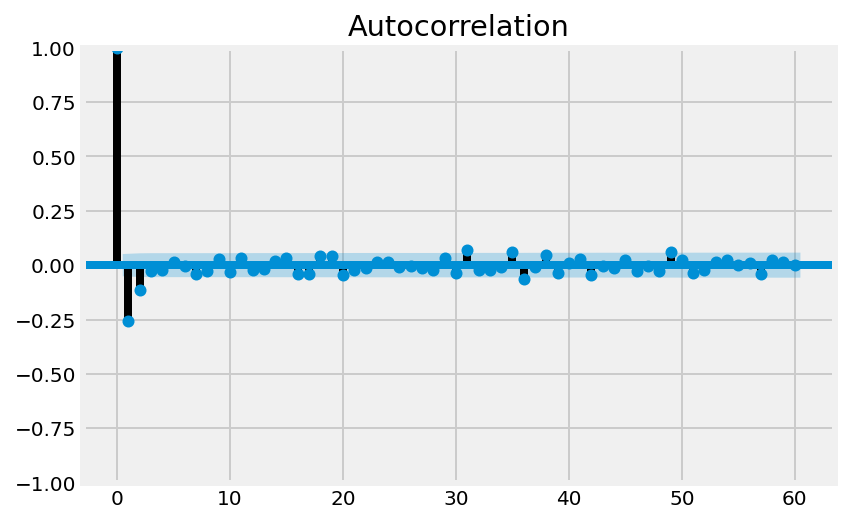

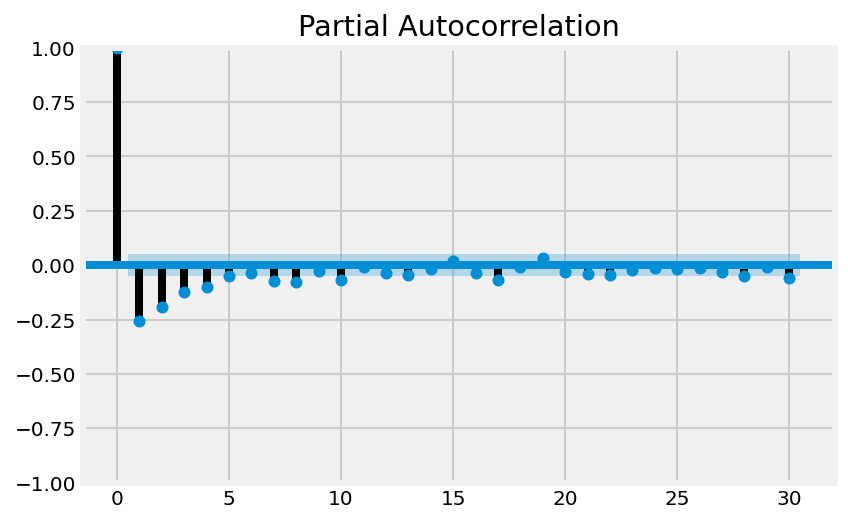

In [ ]:
graph1=plot_acf(dif_dataset,lags=60,adjusted=False)
graph2=plot_pacf(dif_dataset,lags=30,method='ldbiased')

A partir de los correlogramas se sugiere el ajuste de un modelo $ARIMA(2,1,8)$ o $ARIMA(2,1,4)$. El modelo se ajustara en los datos de entrenamiento definidos anteriormente, sin embargo, hagamos uso de autoarima para ver el mejor modelo usando el criterio BIC.

In [ ]:
auto = auto_arima(X_train, error_action='ignore',max_p=5,d=1,max_q=5,max_order=10,seasonal=True,information_criterion='bic')
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1465
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -1402.511
Date:                Sun, 20 Nov 2022   AIC                           2815.023
Time:                        21:35:59   BIC                           2841.467
Sample:                    01-01-2017   HQIC                          2824.886
                         - 01-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8909      0.027     33.358      0.000       0.839       0.943
ma.L1         -1.2718      0.034    -37.576      0.000      -1.338      -1.206
ma.L2          0.1720      0.036      4.759      0.000       0.101       0.243
ma.L3          0.1128      0.030      3.762      0.000       0.054       0.172
sigma2         0.3975      0.009     44.648      0.000       0.380       0.415
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               805.43
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.13
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
modeloarima1=sm.tsa.SARIMAX(X_train, trend='n', order=(2,1,8))
ajustearima1=modeloarima1.fit()
print('ARIMA(2,1,8)')
print(ajustearima1.summary())
modeloarima2=sm.tsa.SARIMAX(X_train, trend='n', order=(2,1,4))
ajustearima2=modeloarima2.fit()
print('ARIMA(2,1,4)')
print(ajustearima2.summary())
modeloarima3=sm.tsa.SARIMAX(X_train, trend='n', order=(1,1,3))
ajustearima3=modeloarima3.fit()
print('ARIMA(1,1,3)')
print(ajustearima3.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA(2,1,8)
                               SARIMAX Results                                
Dep. Variable:         ValorObservado   No. Observations:                 1465
Model:               SARIMAX(2, 1, 8)   Log Likelihood               -1400.135
Date:                Sun, 20 Nov 2022   AIC                           2822.271
Time:                        21:36:04   BIC                           2880.449
Sample:                    01-01-2017   HQIC                          2843.971
                         - 01-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0998      0.059     -1.689      0.091      -0.216       0.016
ar.L2          0.8366      0.061     13.806      0.000       0.718       0.955
ma.L1         -0.2757      0.064     -4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



ARIMA(2,1,4)
                               SARIMAX Results                                
Dep. Variable:         ValorObservado   No. Observations:                 1465
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -1400.426
Date:                Sun, 20 Nov 2022   AIC                           2814.853
Time:                        21:36:07   BIC                           2851.875
Sample:                    01-01-2017   HQIC                          2828.662
                         - 01-04-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0820      0.034     -2.386      0.017      -0.149      -0.015
ar.L2          0.8594      0.033     25.784      0.000       0.794       0.925
ma.L1         -0.2964      0.042     -7

Por lo tanto el modelo seleccionado es el ARIMA(1,1,3)

In [ ]:
ARIMA_mod=sm.tsa.SARIMAX(X_train, trend='n', order=(1,1,3))
ARIMA_model=ARIMA_mod.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



#### <font color= blue> Análisis de Residuales </font>

**Homocedasticidad, Normalidad y Correlogramas**

array([[8.05434120e+002, 1.26532803e-175, 1.29577133e-001,
        6.62445542e+000]])

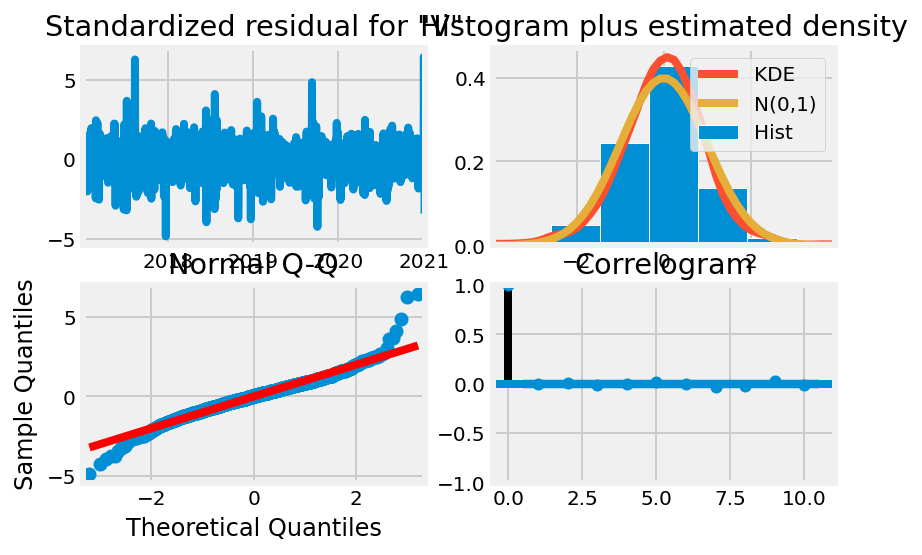

In [ ]:
#####Análisis de Residuales######
residuales=ARIMA_model.resid####Residuales no estandarizados

graf_resid=ARIMA_model.plot_diagnostics()
#plt.show()
## Hipótesis nula de no heterocedasticidad
ARIMA_model.test_heteroskedasticity(method='breakvar') #[Est. de prueba, p-valor]
## Hipótesis nula de normalidad
ARIMA_model.test_normality(method='jarquebera')
#1. Estadística de prueba
#2. El p valor
#3. Sesgo estimado de los datos
#4. Curtosis estimada
## Hipótesis nula indica que no se presenta correlación serial

**Gráficas CUSUM y CUSUM CUADRADO**

Text(0.5, 1.0, 'Estadística Cusum')

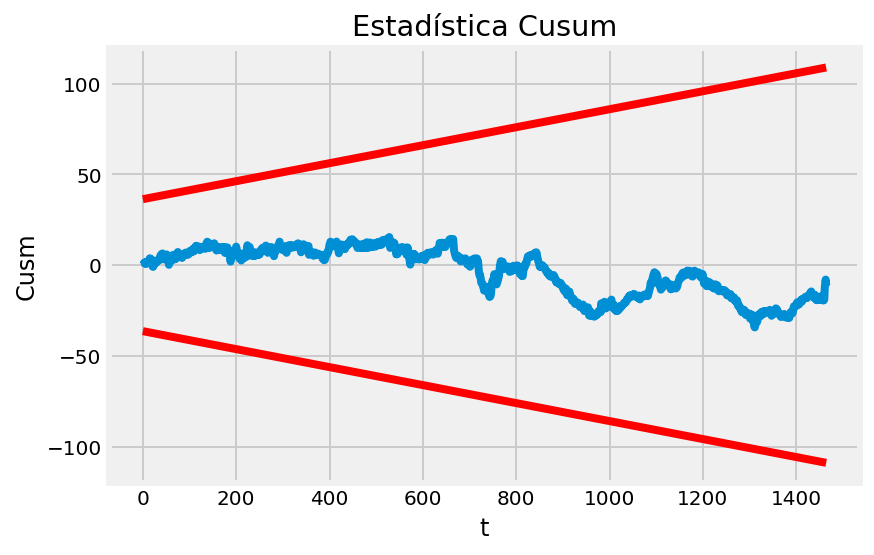

In [ ]:
Res_estand=ajustearima3.standardized_forecasts_error.reshape(1465,)

##CUSUM
cum=Res_estand.cumsum()
N=len(Res_estand)
N
Af_cusum=0.948###Cuantil estadística cusum
LS=Af_cusum*math.sqrt(N)+2*Af_cusum*np.arange(1,N+1)/math.sqrt(N)
LI=-LS
plt.plot(cum)
plt.plot(LS,color='red')
plt.plot(LI,color='red')
plt.xlabel("t")
plt.ylabel("Cusm")
plt.title('Estadística Cusum')


Text(0.5, 1.0, 'Estadística Cusumsq')

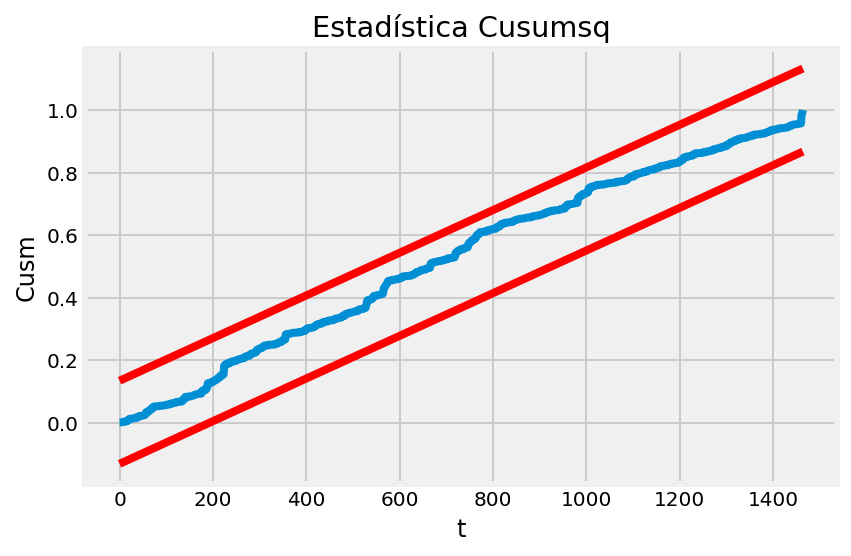

In [ ]:
#CUSUMQ
cumq=(Res_estand**2).cumsum()/sum(Res_estand**2)
co=0.13291####Valor del cuantil aproximado para cusumsq para n/2
LQS=co+np.arange(1,N+1)/N
LQI=-co+np.arange(1,N+1)/N
plt.plot(cumq)
plt.plot(LQS,color='red')
plt.plot(LQI,color='red')
plt.xlabel("t")
plt.ylabel("Cusm")
plt.title('Estadística Cusumsq')

#### <font color= blue> Predicciones usando Rolling </font>

In [ ]:
## Rolling
from sklearn.metrics import mean_squared_error

val = df.values
size = len(df[:1465])
train, test = val[1:size], val[size:len(val)]
history = [x for x in train]
predicciones = list()
for t in range(len(test)):
	modelo = sm.tsa.statespace.SARIMAX(history, trend='n', order=(1,1,3))
	modelo_fit = modelo.fit(disp=0)
	output = modelo_fit.forecast()
	yhat = output[0]
	predicciones.append(yhat)
	obs = test[t]
	history.append(obs)
	print('Predicción=%f, Esperado=%f' % (yhat, obs))

Predicción=12.167299, Esperado=11.939085
Predicción=12.180234, Esperado=11.939085
Predicción=11.959892, Esperado=11.939085
Predicción=11.899791, Esperado=11.939085
Predicción=11.859121, Esperado=13.904167
Predicción=13.064467, Esperado=14.095833
Predicción=13.309887, Esperado=14.689583
Predicción=13.888538, Esperado=14.812500
Predicción=14.104557, Esperado=14.525000
Predicción=14.045700, Esperado=14.435417
Predicción=14.037913, Esperado=14.772917
Predicción=14.263743, Esperado=14.225000
Predicción=13.947992, Esperado=14.554167
Predicción=14.163448, Esperado=15.037500
Predicción=14.469618, Esperado=14.262500
Predicción=14.040004, Esperado=13.660417
Predicción=13.661801, Esperado=14.210417
Predicción=13.929279, Esperado=14.185417
Predicción=13.888321, Esperado=14.747917
Predicción=14.276035, Esperado=14.202083
Predicción=13.976192, Esperado=13.739583
Predicción=13.708270, Esperado=13.775000
Predicción=13.675909, Esperado=13.952083
Predicción=13.747958, Esperado=14.037500
Predicción=13.80

In [ ]:
d=pd.DataFrame(predicciones)
d=d.set_index(df.index[len(X_train):])
d=pd.concat([d, X_test], axis=1)
d['ARIMA_Predict']=d[0]
joblib.dump(d,'/content/drive/Shareddrives/Mineria /ARIMA_Predict')

['/content/drive/Shareddrives/Mineria /ARIMA_Predict']

In [ ]:
# plot y_train, y_test, and testPredict using plotly
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df.index[: len(X_train)],
        y=X_train['ValorObservado'],
        mode="lines",
        name="Entrenamiento",
    )
)
fig.add_trace(
    go.Scatter(
        x=df.index[len(X_train):],
        y=X_test['ValorObservado'],
        mode="lines",
        name="Prueba",
    )
)
fig.add_trace(
    go.Scatter(
        x=df.index[len(X_train):],
        y=d.ARIMA_Predict,
        mode="lines",
        name="Predicción",
    )
)
fig.update_xaxes(title_text="Fecha")
fig.update_yaxes(title_text="ValorObservado")
fig.show()

#### <font color= blue> ECM usando Rolling </font>

In [ ]:
error = mean_squared_error(d.ValorObservado, d.ARIMA_Predict)
print('Test Score: %.2f RMSE' % (error))

Test Score: 0.69 RMSE
